In [ ]:
! pip install atari-py 
! wget http://www.atarimania.com/roms/Roms.rar
! unrar x Roms.rar
! python -m atari_py.import_roms 
! unzip ROMS.zip
! python -m atari_py.import_roms ROMS

In [2]:
import torch
import numpy as np
import seaborn as sns
from tqdm import tqdm

vmin,vmax = -10.,10. 
nsup=51 
support = np.linspace(vmin,vmax,nsup) 
probs = np.ones(nsup)
probs /= probs.sum()

In [3]:
def update_dist(r,support,probs,lim=(-10.,10.),gamma=0.8):
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.) 
    bj = np.round((r-vmin)/dz) 
    bj = int(np.clip(bj,0,nsup-1)) 
    m = probs.clone()
    j = 1
    for i in range(bj,1,-1): 
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1): 
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum() 
    return m

In [23]:
def dist_dqn(x,theta,aspace=3): 
    dim0,dim1,dim2,dim3 = 128,100,25,51 
    t1 = dim0*dim1
    t2 = dim2*dim1
    theta1 = theta[0:t1].reshape(dim0,dim1) 
    theta2 = theta[t1:t1 + t2].reshape(dim1,dim2)
    l1 = x @ theta1 
    l1 = torch.selu(l1)
    l2 = l1 @ theta2 
    l2 = torch.selu(l2)
    l3 = []
    for i in range(aspace): 
        step = dim2*dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2,dim3)
        l3_ = l2 @ theta5 
        l3.append(l3_)
    l3 = torch.stack(l3,dim=1) 
    l3 = torch.nn.functional.softmax(l3,dim=2)
    return l3.squeeze()

In [5]:
def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    nsup = support.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]):
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: 
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else: 
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist 
        
    return target_dist_batch

In [31]:
def lossfn(x,y):
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]): 
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0) 
        loss = loss + loss_
    return loss

In [67]:
def preproc_state(state):
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state,dim=1)
    return p_state

def variance(dist, support):
  return torch.sum((support - (support @ dist))**2)/(nsup - 1)

def get_action(dist,support):
    actions = []
    for b in range(dist.shape[0]): 
        expectations = [(support @ dist[b,a,:])/variance(dist[b, a, :], support) for a in range(dist.shape[1])]
        action = int(np.argmax(expectations)) 
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [68]:
import gym
from collections import deque
env = gym.make('Freeway-ram-v0')
aspace = 3
env.env.get_action_meanings()

vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,vmax,nsup)

replay = deque(maxlen=replay_size) 
lr = 0.0001 
gamma = 0.1 
epochs = 1300
eps = 0.20
eps_min = 0.05 
priority_level = 5 
update_freq = 25 

tot_params = 128 * 100 + 100 * 25 + aspace * 25 * 51 
theta = torch.randn(tot_params)/10.
theta.requires_grad=True
theta_2 = theta.detach().clone() 

losses = []
cum_rewards = [] 
renders = []
state = preproc_state(env.reset())

In [69]:
from random import shuffle

for i in tqdm(range(epochs)):
    pred = dist_dqn(state,theta,aspace=aspace)
    if i < replay_size or np.random.rand(1) < eps: 
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(),support).item()
    state2, reward, done, info = env.step(action) 
    state2 = preproc_state(state2)
    if reward == 1: cum_rewards.append(1) 
    reward = 10 if reward == 1 else reward 
    reward = -10 if done else reward 
    reward = -1 if reward == 0 else reward 
    exp = (state,action,reward,state2) 
    replay.append(exp)
    
    if reward == 10: 
        for e in range(priority_level):
            replay.append(exp)
            
    shuffle(replay)
    state = state2

    if len(replay) == replay_size: 
        indx = np.random.randint(low=0,high=len(replay),size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps],dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps],dim=1).squeeze()
        pred_batch = dist_dqn(state_batch.detach(),theta,aspace=aspace)
        pred2_batch = dist_dqn(state2_batch.detach(),theta_2,aspace=aspace)
        target_dist = get_target_dist(pred2_batch,action_batch,reward_batch, \
                                     support, lim=(vmin,vmax),gamma=gamma)
        loss = lossfn(pred_batch,target_dist.detach())

        losses.append(loss.item())
        loss.backward()
        with torch.no_grad(): 
            theta -= lr * theta.grad
        theta.requires_grad = True
        
    if i % update_freq == 0: 
        theta_2 = theta.detach().clone()
        
    if i > 100 and eps > eps_min: 
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
    
    if done: 
        state = preproc_state(env.reset())
        done = False

100%|██████████| 1300/1300 [01:27<00:00, 14.83it/s]


100%|██████████| 100/100 [07:01<00:00,  4.22s/it]


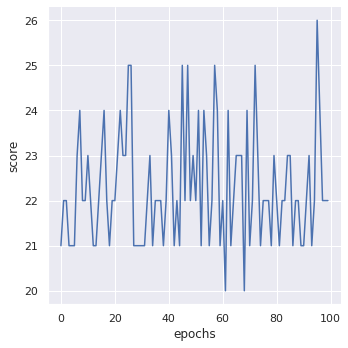

In [71]:
import seaborn as sns
sns.set_theme()

scores = []
for i in tqdm(range(100)):
  state = preproc_state(env.reset())
  done = False
  total = 0
  while done != True:
    pred = dist_dqn(state, theta, aspace = aspace)
    action = get_action(pred.unsqueeze(dim=0).detach(), support).item()
    (state, reward, done, info) = env.step(action)
    total += reward
    state = preproc_state(state)
  scores.append(total)
sns.relplot(data=scores, kind="line").set(xlabel='epochs', ylabel='score')